<a href="https://colab.research.google.com/github/shashwatijha/WheatClassification/blob/main/wheat_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 13.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=08bd0d42f3610efdaac248dc90ccdab7c23ae7828af1ed927af8a7a25f849290
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 663kB/s 
     |████████████████████████████████| 2.2MB 12.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201204-cp36-none-any.whl size=44622 sha256=3fcbd67c75420d5f357faa286900ea1960259d7c81efa088ef3e6b699bdcb029
  Stored in directory: /root/.cache/pip/wheels/b7/c9/47/dc3ce6f67e8cbfb4dec8e9ce981a2aa67b56525d7b91b510af
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


## Get data

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
!unzip wheatsegmentation.zip
!ls

Archive:  wheatsegmentation.zip
   creating: Wheat segmentation/
  inflating: Wheat segmentation/labelme2coco.py  
   creating: Wheat segmentation/test/
  inflating: Wheat segmentation/test/IMG_3012.jpg  
  inflating: Wheat segmentation/test/IMG_3012.json  
  inflating: Wheat segmentation/test/IMG_3017.jpg  
  inflating: Wheat segmentation/test/IMG_3017.json  
  inflating: Wheat segmentation/test/IMG_3033.jpg  
  inflating: Wheat segmentation/test/IMG_3033.json  
  inflating: Wheat segmentation/test/IMG_3037.jpg  
  inflating: Wheat segmentation/test/IMG_3037.json  
  inflating: Wheat segmentation/test/IMG_3040.jpg  
  inflating: Wheat segmentation/test/IMG_3040.json  
  inflating: Wheat segmentation/test/IMG_3074.jpg  
  inflating: Wheat segmentation/test/IMG_3074.json  
  inflating: Wheat segmentation/test/IMG_3079.jpg  
  inflating: Wheat segmentation/test/IMG_3079.json  
  inflating: Wheat segmentation/test.json  
   creating: Wheat segmentation/train/
  inflating: Wheat segmentati

In [ ]:
!ls 'Wheat segmentation'

labelme2coco.py  test  test.json  train  train.json


## Register data-set

In order to use a dataset with Detectron2 we need to register it.


In [ ]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"Wheat_{d}", {}, f"Wheat segmentation/{d}.json", f"Wheat segmentation/{d}")

WARNING [12/04 09:57:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/04 09:57:27 d2.data.datasets.coco]: Loaded 30 images in COCO format from Wheat segmentation/train.json


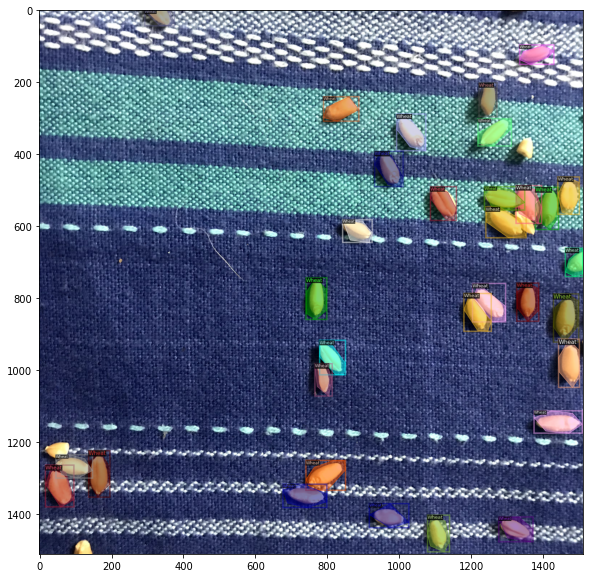

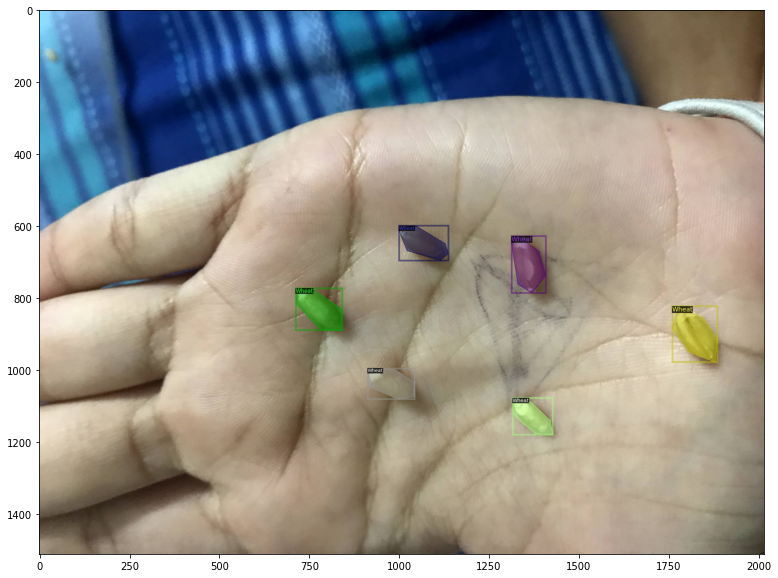

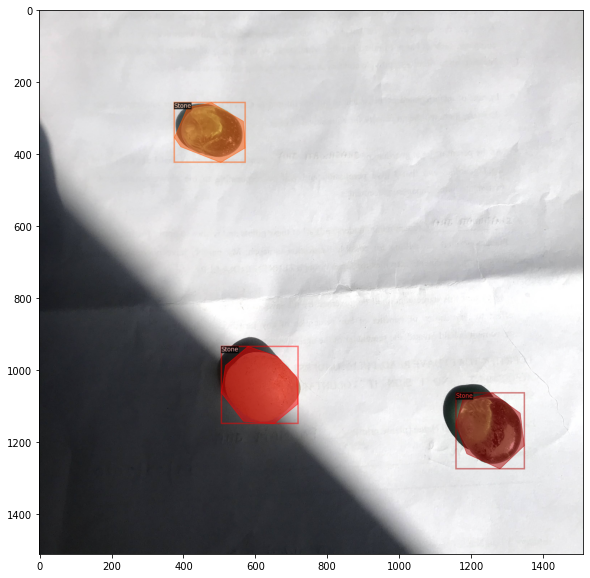

In [ ]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("Wheat_train")
Wheat_metadata = MetadataCatalog.get("Wheat_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=Wheat_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model



In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Wheat_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/04 10:02:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:08, 21.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[12/04 10:02:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/

[12/04 10:02:36 d2.utils.events]:  eta: 0:12:03  iter: 19  total_loss: 2.485  loss_cls: 1.161  loss_box_reg: 0.4789  loss_mask: 0.6943  loss_rpn_cls: 0.0453  loss_rpn_loc: 0.02214  time: 0.7883  data_time: 0.4242  lr: 4.9953e-06  max_mem: 2662M
[12/04 10:02:52 d2.utils.events]:  eta: 0:12:17  iter: 39  total_loss: 2.304  loss_cls: 1.054  loss_box_reg: 0.452  loss_mask: 0.6839  loss_rpn_cls: 0.05542  loss_rpn_loc: 0.02366  time: 0.8120  data_time: 0.4574  lr: 9.9902e-06  max_mem: 2662M
[12/04 10:03:08 d2.utils.events]:  eta: 0:11:50  iter: 59  total_loss: 2.136  loss_cls: 0.8353  loss_box_reg: 0.5041  loss_mask: 0.6543  loss_rpn_cls: 0.06404  loss_rpn_loc: 0.02698  time: 0.8034  data_time: 0.3904  lr: 1.4985e-05  max_mem: 2792M
[12/04 10:03:24 d2.utils.events]:  eta: 0:11:40  iter: 79  total_loss: 1.895  loss_cls: 0.6554  loss_box_reg: 0.5626  loss_mask: 0.6157  loss_rpn_cls: 0.02504  loss_rpn_loc: 0.01971  time: 0.8076  data_time: 0.4301  lr: 1.998e-05  max_mem: 2792M
[12/04 10:03:40 d

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("Wheat_test", )
predictor = DefaultPredictor(cfg)

WARNING [12/04 10:34:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/04 10:34:26 d2.data.datasets.coco]: Loaded 30 images in COCO format from Wheat segmentation/train.json


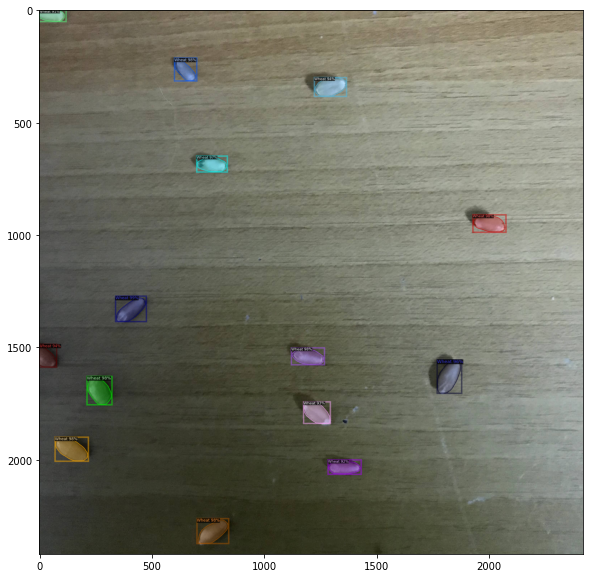

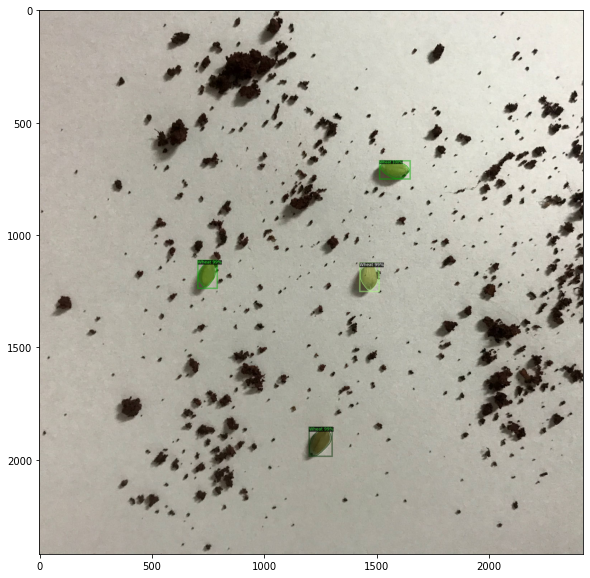

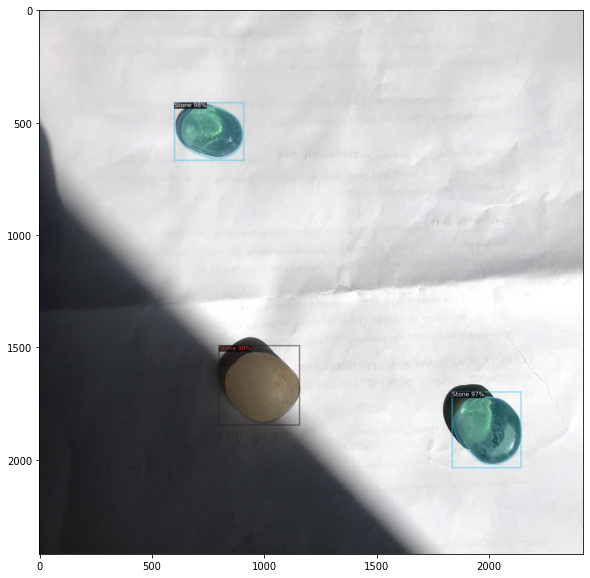

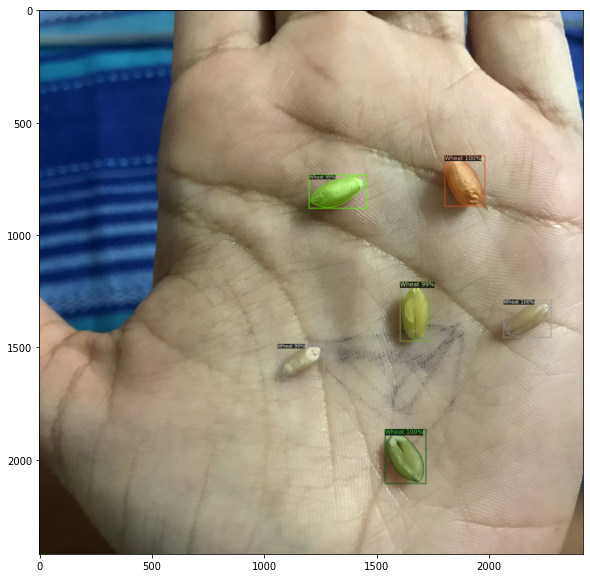

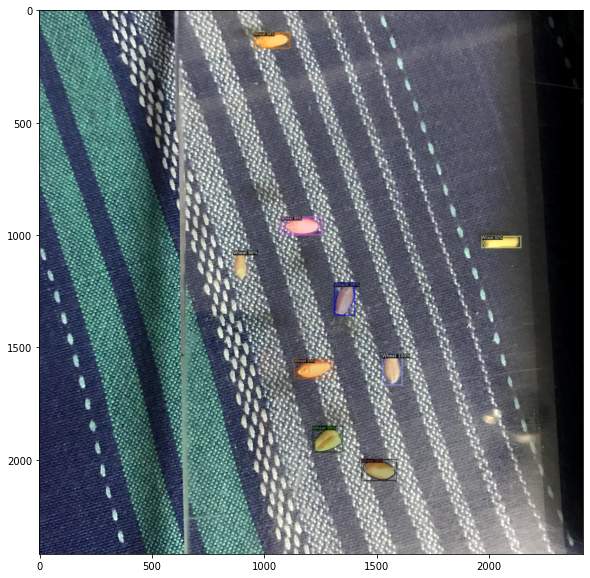

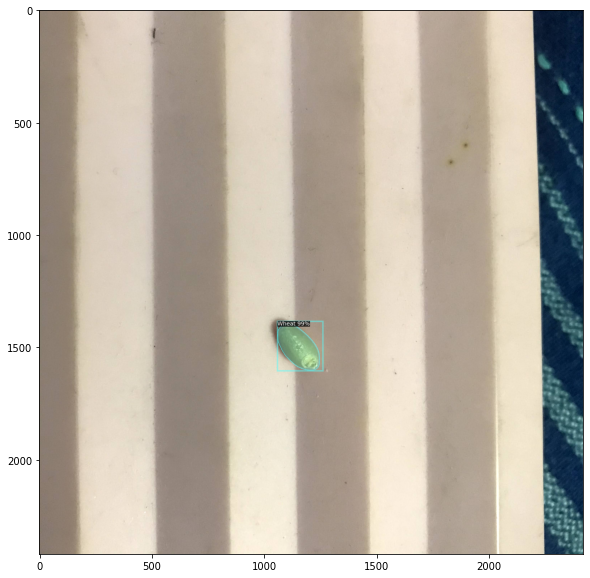

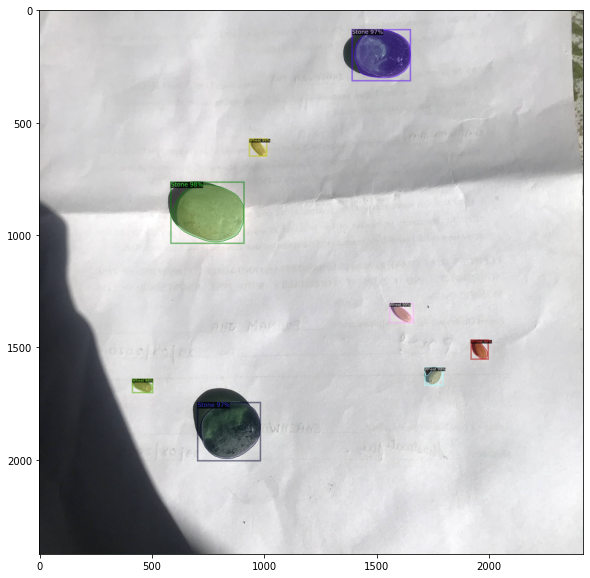

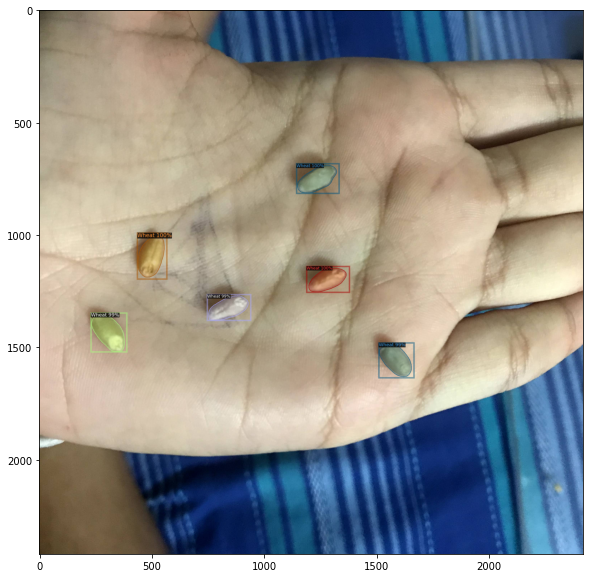

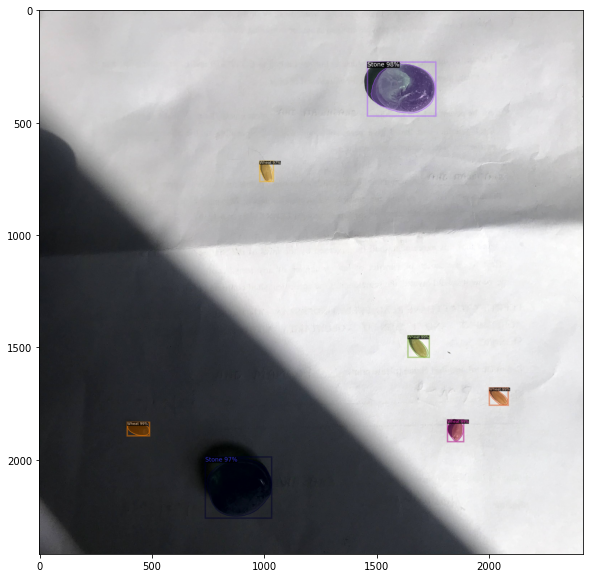

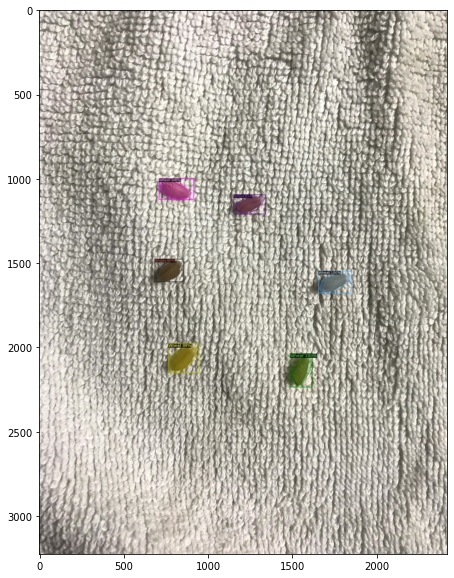

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("Wheat_train")
for d in random.sample(dataset_dicts, 10):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=Wheat_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()